In [1]:
import numpy as np
import tifffile
import math
from collections import Counter
import json
import os
from pykowski.karambola import KarambolaResults
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Porestats(object):
    def __init__(self, data):
        self.name = data["name"]
        
        self.porosity = data["porosity"]
        self.porosity_sq = self.porosity*self.porosity
        
        #Covariance: C(x) = cov(x)+Vv^2
        self.covariance_x = np.array(data["x"])
        self.covariance_y =  np.array(data["y"])
        self.covariance_z =  np.array(data["z"])
        
        self.covariance_averaged = np.array(data["averaged"])
        
        #Covariance Function: cov(x) = C(x)-Vv^2
        self.covariance_function_x = self.covariance_x-self.porosity_sq
        self.covariance_function_y = self.covariance_y-self.porosity_sq
        self.covariance_function_z = self.covariance_z-self.porosity_sq
        
        self.covariance_function_averaged = self.covariance_averaged-self.porosity_sq
        
        #Normalized Covariance Function: cov(x)/(Vv-Vv^2)
        self.normalized_covariance_x = np.divide(self.covariance_function_x, self.porosity-self.porosity_sq)
        self.normalized_covariance_y = np.divide(self.covariance_function_y, self.porosity-self.porosity_sq)
        self.normalized_covariance_z = np.divide(self.covariance_function_z, self.porosity-self.porosity_sq)
        
        self.normalized_covariance_averaged = np.divide(self.covariance_function_averaged, self.porosity-self.porosity_sq)
        
        self.fit_x = None
        self.fit_y = None
        self.fit_z = None
        
        self.fit_averaged = None
        
        self.poly_x = None
        self.poly_y = None
        self.poly_z = None
        
        self.poly_averaged = None
        
        self.fit_poly()
        
    def fit_poly(self, N=10, res=1):
        self.fit_x = np.polyfit(np.array(range(len(self.covariance_x[0:N])))*res, self.covariance_x[0:N], 1)
        self.poly_x = np.poly1d(self.fit_x)
        
        self.fit_y = np.polyfit(np.array(range(len(self.covariance_y[0:N])))*res, self.covariance_y[0:N], 1)
        self.poly_y = np.poly1d(self.fit_y)
        
        self.fit_z = np.polyfit(np.array(range(len(self.covariance_z[0:N])))*res, self.covariance_z[0:N], 1)
        self.poly_z = np.poly1d(self.fit_z)
        
        self.fit_averaged = np.polyfit(np.array(range(len(self.covariance_averaged[0:N])))*res, self.covariance_averaged[0:N], 1)
        self.poly_averaged = np.poly1d(self.fit_averaged)
        
        self.rc_x = (self.porosity_sq-self.porosity)/self.poly_x[1]
        self.rc_y = (self.porosity_sq-self.porosity)/self.poly_y[1]
        self.rc_z = (self.porosity_sq-self.porosity)/self.poly_z[1]
        
        self.rc_averaged = (self.porosity_sq-self.porosity)/self.poly_averaged[1]
    
    def compute_Sv(self, resolution=1., direc_frac=[1., 1., 1.]):
        self.Sv_i = [-2./direc_frac[0]*self.poly_x[1]*1./resolution, -2./direc_frac[1]*self.poly_y[1]*1./resolution, -2./direc_frac[2]*self.poly_z[1]*1./resolution]
        self.Sv_average = -4*self.poly_averaged[1]*1./resolution
        
    def compute_kozeny_carman_perm(self):
        self.kozeny_i = [(self.porosity**3)/((1-self.porosity)**2)*1./(val**2) for val in self.Sv_i]
        self.kozeny_average = (self.porosity**3)/((1-self.porosity)**2)*1./(self.Sv_average**2) 
        
    def compute_kozeny_constant(self, permeability):
        self.kozeny_c_i = [kozeny/perm for kozeny, perm in zip(self.kozeny_i, permeability)]
        self.kozeny_c_average = self.kozeny_average/np.mean(permeability)

In [3]:
names = ["estaillades"]

In [17]:
resolution_file = "image_data/resolutions.json"
with open(resolution_file) as data_file:
    resolutions = json.load(data_file)
    
dimensions_file = "image_data/dimensions.json"
with open(dimensions_file) as data_file:
    dimensions = json.load(data_file)
    
permeability_file = "permeability_results/permeability_tensors_edit.json"
with open(permeability_file) as data_file:
    permeability = json.load(data_file)
    
interface_results_dir = "interface_results/"
interface_data = {}

for file in os.listdir(interface_results_dir):
        if file.endswith(".json"):
            with open(interface_results_dir+file) as data_file:
                data = json.load(data_file)
                interface_data[data["name"]] = data
                
covariance_results_dir = "covariance_results/"
porestats_objs = {}

for file in os.listdir(covariance_results_dir):
        if file.endswith(".json"):
            with open(covariance_results_dir+file) as data_file:
                data = json.load(data_file)
                porestats_objs[data["name"]] = Porestats(data)

                
minkowski_data = {}
for sample_name in names:
    minkowski_data[sample_name] = {}
    
    json_files = []
    
    for file in os.listdir("minkowski_results/karambola_output/"+sample_name):
        if file.endswith(".json"):
            json_files.append(file)

    dxs = []
    results = []
    for file_name in json_files:
        data = None
        with open("minkowski_results/karambola_output/"+sample_name+"/"+file_name, 'r') as f:
            for row in f:
                data = row
        name = file_name.split("_")
        dx = int(name[0])
        json_data = json.loads(data)
        karam_res = KarambolaResults()
        karam_res.load_from_json_format(json_data)
        #if karam_res.w202 is not 'ERROR' and karam_res.w102 is not 'ERROR':
        try:
            karam_res.compute_eigenvalues()
            dxs.append(dx)
            results.append(karam_res)
        except:
            print "Non-Manifold mesh in "+file_name

    w102s =  [x.w102 for x in results]
    w100s = [x.w100 for x in results]
    beta_102s = [x.beta_102 for x in results]
    beta_202s = [x.beta_202 for x in results]
    gamma_102s = [x.gamma_102 for x in results]
    gamma_202s = [x.gamma_202 for x in results]

    dxs_sorted = sorted(dxs)
    
    w102s_sorted = [x for (y,x) in sorted(zip(dxs, w102s))]
    w100s_sorted = [x for (y,x) in sorted(zip(dxs, w100s))]
    
    beta_102s_sorted = [x for (y,x) in sorted(zip(dxs, beta_102s))]
    beta_202s_sorted = [x for (y,x) in sorted(zip(dxs, beta_202s))]
    gamma_102s_sorted = [x for (y,x) in sorted(zip(dxs, gamma_102s))]
    gamma_202s_sorted = [x for (y,x) in sorted(zip(dxs, gamma_202s))]
    minkowski_data[sample_name]["dx"] = dxs_sorted
    minkowski_data[sample_name]["beta_102"] = beta_102s_sorted
    minkowski_data[sample_name]["beta_202"] = beta_202s_sorted
    minkowski_data[sample_name]["gamma_102"] = gamma_102s
    minkowski_data[sample_name]["gamma_202"] = gamma_202s
    minkowski_data[sample_name]["w100"] = w100s_sorted
    minkowski_data[sample_name]["w102"] = w102s_sorted

In [16]:
names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "C1", "C2", "Berea", 
         "Isotropic12", "Isotropic13", "Anisotropic121214", "Anisotropic131314",
         "beadpack", "ketton","bentheimer", "estaillades"]#, "doddington"]

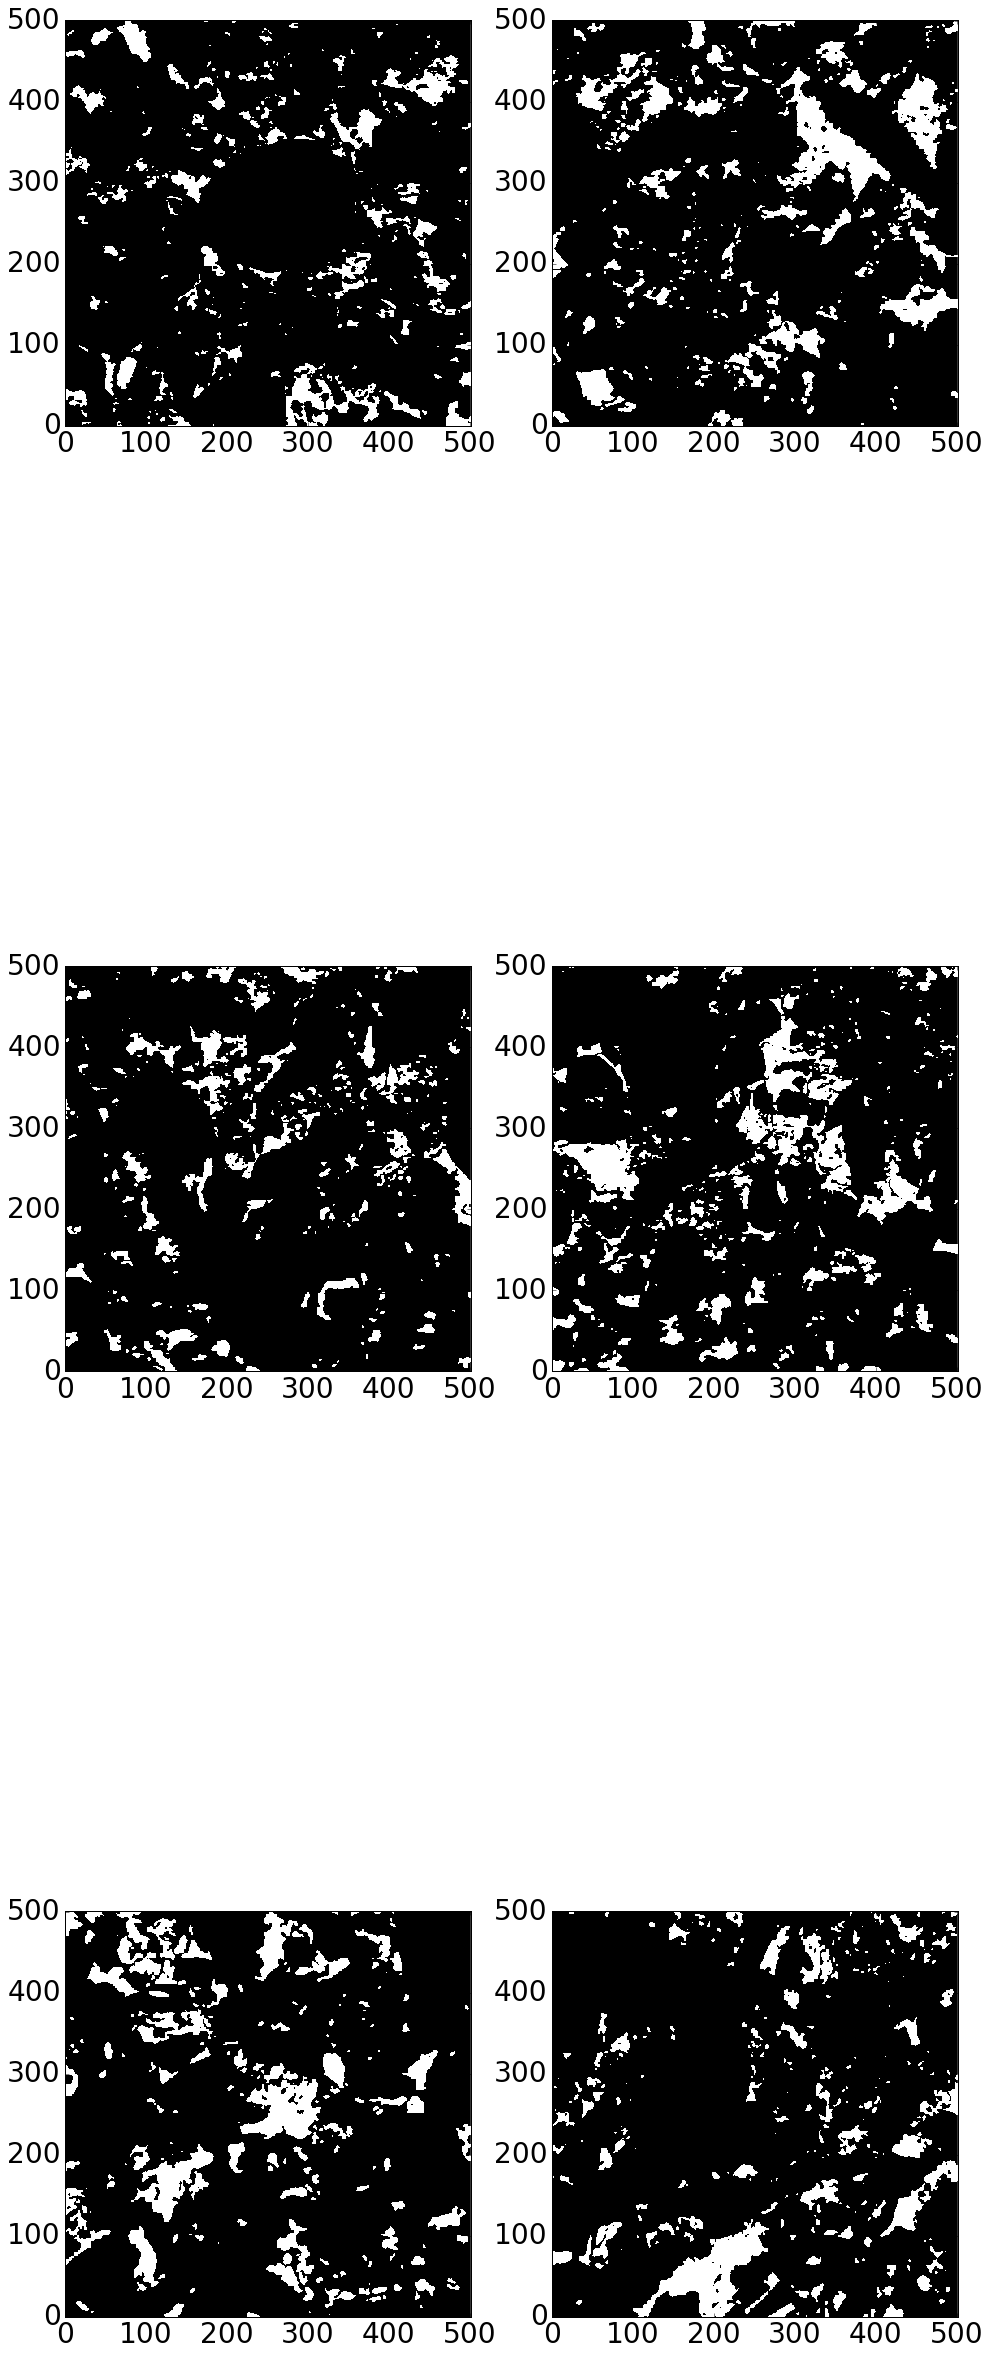

In [84]:
fig, axarr = plt.subplots(3, 2, figsize=(16, 48))

for ax, image in zip(axarr.flatten(), [front_face, back_face, left_face, right_face, top_face, bottom_face]):

    #ax.set_title(title, size=45, y=1.05)

    #labels = [item.get_text() for item in ax.get_yticklabels()]
    #print labels
    #ax.set_yticklabels(labels[::-1])

    ax.imshow(image, cmap='Greys',  interpolation='nearest')
    for item in ax.get_xticklabels():
        item.set_fontsize(28)
    for item in ax.get_yticklabels():
        item.set_fontsize(28)

    #ax.set_xlabel(x_label, size=40)
    #ax.set_ylabel(y_label, size=40)
    ax.set_xlim(0, im.shape[0]+1)
    ax.set_ylim(0, im.shape[1]+1)
fig.canvas.draw()

plt.show()
#fig.savefig("binary_views/"+name+"_binary_views.png", bbox_extra_artists=None, bbox_inches='tight', dpi=300)
plt.close()

In [11]:
for name in names:
    print name
    im = tifffile.imread("image_data/images/"+name+".tif")
    res = resolutions[name]
    dim = dimensions[name]
    porosity = porestats_objs[name].porosity
    
    front_face = im[:, :, 0]
    back_face = im[:,  :, -1]
    left_face = im[:, 0, :]
    right_face = im[:, -1, :]
    top_face = im[0, :, :]
    bottom_face = im[-1, :, :]
    
    front_count = Counter(front_face.flatten())[0]
    back_count = Counter(back_face.flatten())[0]
    left_count = Counter(left_face.flatten())[0]
    right_count = Counter(right_face.flatten())[0]
    top_count = Counter(top_face.flatten())[0]
    bottom_count = Counter(bottom_face.flatten())[0]
    
    x_count = front_count+back_count
    y_count = left_count+right_count
    z_count = top_count+bottom_count
    
    #Compute Volume and equivalent radius
    Vo = (dim*res)**3
    So = float(6*(dim*dim))*res*res
    V_alpha = Vo*porosity
    R_eq = np.power(3.*Vo/4.*1./np.pi, 1./3.)
    
    S_alpha_alpha = (x_count+y_count+z_count)*res*res
    S_alpha_beta = 3*res*res*minkowski_data[name]["w100"][-1]
    phi_alpha_s = S_alpha_alpha/So
    print "Pore Area: ", S_alpha_alpha
    print "Volume Area: ", So
    print "Areal Porosity: ", phi_alpha_s
    
    print "Pore Grain Area: ", S_alpha_beta
    
    
    #compute orientation term
    normed_w102 = (minkowski_data[name]["w102"][-1]/minkowski_data[name]["w100"][-1])
    print normed_w102
    print "Alpha_ij^-1"
    #print alpha_ij_lower

    #alpha_ij_lower = np.array([[1, 0, 0], [0, 1,0], [0, 0, 1]])+normed_w102
    alpha_ij_upper =  np.identity(3)-normed_w102
    print alpha_ij_upper
    alpha_ij_over_upper = np.linalg.inv(alpha_ij_upper)#np.divide(1., alpha_ij_upper)
    #alpha_ij_over_lower = np.linalg.inv(alpha_ij_lower)#np.divide(1., alpha_ij_lower)
    

    #phi_alpha_s = (front_count+back_count+left_count+right_count+top_count+bottom_count)/float(6*(dim*dim))
    print "Porosity: ", porosity
    print "Bear factor: ", 3*phi_alpha_s/porosity
    print ""

    tortuosity = np.array([[x_count, 0, 0], [0, y_count, 0], [0, 0, z_count]])/float((x_count+y_count+z_count))
    tort_fac = R_eq*(phi_alpha_s/porosity)*(So/Vo)*tortuosity
    print tort_fac

    specific_area_pores = S_alpha_beta/Vo
    specific_area_grains = specific_area_pores/(1.-porosity)
    
    
    print "Specific Area Pores: ", specific_area_pores
    kozeny_factor = 1.
    kij_upper = (porosity*porosity*porosity)/  \
                (kozeny_factor*((1.-porosity)*(1.-porosity))*(specific_area_grains*specific_area_grains)) \
                *alpha_ij_over_upper#np.multiply(alpha_ij_over_upper, tort_fac)
    
    kij_other =  (porosity*porosity*porosity)/  \
                (kozeny_factor*(specific_area_pores*specific_area_pores)) \
                *alpha_ij_over_upper#np.multiply(alpha_ij_over_upper, tort_fac)
    
    #kij_lower = (porosity*porosity*porosity)/  \
    #            (kozeny_factor*((1.-porosity)*(1.-porosity))*(specific_area_grains*specific_area_grains)) \
    #            *alpha_ij_over_lower#np.multiply(alpha_ij_over_lower, tort_fac)
    print kij_upper
    print kij_other
    #print kij_lower
    k_measured = [permeability[name]["kx"], 0., 0.],[0., permeability[name]["ky"], 0.], [0., 0., permeability[name]["kz"]]
    print "measured k"
    factor = np.divide(kij_upper, k_measured)
    print k_measured#np.divide(kij, k_measured)
    print kij_upper*1./factor
    
    """
    if kij_lower[0][0] <= k_measured[0][0] <= kij_upper[0][0]:
        print "x True"
    else:
        print "x False"
    if kij_lower[1][1] <= k_measured[1][1] <= kij_upper[1][1]:
        print "y True"
    else:
        print "y False"
    if kij_lower[2][2] <= k_measured[2][2] <= kij_upper[2][2]:
        print "z True"
    else:
        print "z False"
    """
    print np.divide(kij_upper, k_measured)
    #print np.divide(kij_lower, k_measured)
    break
    print ""
    
    """
    t_tensor_up = 3*alpha_ij_upper-2*np.identity(3)
    
    #print t_tensor_new
    t_tensor_low = 3*alpha_ij_lower-2*np.identity(3)
    #print t_tensor_new
    
    kij_upper = (porosity*porosity*porosity)/  \
                (kozeny_factor*((1.-porosity)*(1.-porosity))*(specific_area_grains*specific_area_grains)) \
                *np.multiply(np.linalg.inv(alpha_ij_upper), np.subtract(alpha_ij_lower,np.identity(3)*2./3.))
            
    kij_lower = (porosity*porosity*porosity)/  \
                (kozeny_factor*((1.-porosity)*(1.-porosity))*(specific_area_grains*specific_area_grains)) \
                *np.multiply(np.linalg.inv(alpha_ij_lower), np.subtract(alpha_ij_lower,np.identity(3)*2./3.))
    print ""        
    print kij_upper
    print kij_lower
    print np.divide(kij_upper, k_measured)
    print np.divide(kij_lower, k_measured)

    print np.linalg.inv(alpha_ij_upper)
    print alpha_ij_over_upper
    
    break"""

S1
Pore Area:  6.06337559436e-06
Volume Area:  4.071302406e-05
Areal Porosity:  0.14892962963
Pore Grain Area:  0.000125941157683
[[  2.86698629e-01   3.20890961e-04   4.65074571e-03]
 [  3.20890961e-04   2.94626874e-01  -4.58485870e-03]
 [  4.65074571e-03  -4.58485870e-03   4.18674497e-01]]
Alpha_ij^-1
[[  7.13301371e-01  -3.20890961e-04  -4.65074571e-03]
 [ -3.20890961e-04   7.05373126e-01   4.58485870e-03]
 [ -4.65074571e-03   4.58485870e-03   5.81325503e-01]]
Porosity:  0.141302777778
Bear factor:  3.1619257308

[[ 1.27262765  0.          0.        ]
 [ 0.          1.35491991  0.        ]
 [ 0.          0.          1.2954568 ]]
Specific Area Pores:  7125.15824048
[[  7.79135039e-11   3.13947431e-14   6.23079414e-13]
 [  3.13947431e-14   7.87891645e-11  -6.21151446e-13]
 [  6.23079414e-13  -6.21151446e-13   9.56067584e-11]]
[[  7.79135039e-11   3.13947431e-14   6.23079414e-13]
 [  3.13947431e-14   7.87891645e-11  -6.21151446e-13]
 [  6.23079414e-13  -6.21151446e-13   9.56067584e-11]

C:\Users\lmosser\Anaconda2\lib\site-packages\ipykernel\__main__.py:82: RuntimeWarning: divide by zero encountered in divide
C:\Users\lmosser\Anaconda2\lib\site-packages\ipykernel\__main__.py:100: RuntimeWarning: divide by zero encountered in divide


In [169]:
print 3*minkowski_data["S1"]["w100"][-1]/(300**3)/resolutions["S1"]

7125.15824048


In [171]:
1./7125.**2

1.9698368728839644e-08

In [172]:
print interface_data["S1"]

{u'name': u'S1', u'total_area': 2259238, u'y_interface': 681276, u'x_frac': 0.29587232509368205, u'z_frac': 0.402576443916046, u'y_frac': 0.3015512309902719, u'x_interface': 668446, u'z_interface': 909516}


In [175]:
2259238./300.**3/resolutions["S1"]

9636.701771447826